In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

C:\Users\18gia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('names.txt', 'r') as f:
    words = f.read().split('\n')

In [3]:
#characters mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(chars)+1
print(vocab_size)

27


In [4]:
block_size = 3
def build_dataset(words):
    global block_size
    X , Y = [],[]

    for word in words:

        context = [0] * block_size
        #print(word)
        for ch in word + '.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',itos[ix])
            #update context
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


we see that the initial loss is very high : 27ish
this means that the weights are not initialized properly, indeed they have very large values
since there are 27 characters we can expect the initial loss to be arounf - log(1/27) = 3.3
we can fix this by initializing the weights scaling down the initial logits
we can therefore bring to 0 the tensor b2 and scale down the tensor W2 by multyplying it by 0.1

By doing this we see that the loss has doesn't have anymore a hockey stick shape.Indeed by removing
the large values of the logits we remove the easy gains of squashing down the logits to be more uniform
IN this way the model gets even better because  it spends more time on the hard learnings

----------------------------------------------------------------------------

we also see that a lot of the h values are 1 or -1, this means that the tanh function is saturating.
we can fix this by scaling down the initial weights of the hidden layer
we can therefore bring to 0 the tensor b1 and scale down the tensor W1 by multyplying it by 0.1
if the tanh is saturating it means that the gradient is 0, and the weights are not updated
therefore undermining the learning process
it can happens that a neuron is completely dead ig by chanche all the inputs that connects to him 
provocate the tanh to be -1 or 1, and therefore the gradient is 0

we can also cause a neuron to be dead by using a learning rate that is too high
indeed having a high learning rate means that the gradient is multiplied by a large number
which makes more likely h to be -1 or 1, and therefore the gradient is 0

In [5]:
#MLP
n_emb = 10 #the dimneisonality of the character embedding vector
n_hidden = 200 #number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_emb),                     generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden),        generator=g) * (5/3) / (n_emb * block_size) ** 0.5 #this is the squashing constant that we use to make the variance of the weights in h equal to 1
#b1 = torch.randn(n_hidden,                              generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.01
b2 = torch.randn(vocab_size,                            generator=g) *0

#these gains and biases are added to let the wights move and distort the normal distrubution as they want
bngain = torch.ones(1,n_hidden) 
bnbias = torch.zeros(1,n_hidden)
bnmean_running = torch.zeros(1,n_hidden)
bnstd_running = torch.ones(1,n_hidden)



#these gains and biases are added to let the wights move and distort the normal distrubution as they want
bngain = torch.zeros(1,n_hidden) 
bnbias = torch.zeros(1,n_hidden)
bnmean_running = torch.zeros(1,n_hidden)
bnstd_running = torch.zeros(1,n_hidden)


parameters = [C, W1, W2, b2,bngain, bnbias]
print(sum(p.numel() for p in parameters)) #number of parameters in the model
for p in parameters:
    p.requires_grad = True

12097


In [6]:
#same optimization for all parameters
max_steps = 30000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #random indices
    Xb, Yb = Xtr[ix], Ytr[ix] #batch of X and Y

    #forward pass
    emb = C[Xb] #embedding lookup
    embcat = emb.view(emb.shape[0],-1) #concatenation of the embeddings
    hpreact = embcat @ W1 + # b1 #pre-activation of the hidden layer
    bnmeani = hpreact.mean(dim = 0, keepdim = True)
    bnstdi = hpreact.std(dim = 0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad(): #these are values that we save on the side, there's no need to build a graph since we don't backprogate on them. this make the process more efficient
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running =  0.999 * bnstd_running  + 0.001 * bnstdi

    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #logits
    loss = F.cross_entropy(logits, Yb) #loss 

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #grad updating
    lr = 0.1 if i < max_steps/2 else 0.01 #learning rate decay
    for p in parameters:
        p.data += - lr * p.grad #gradient descent

    #tracking stats
    if i%10000 == 0: 
        print( f'{i:7d}/{max_steps:7d} loss: {loss.item():.3f}') #loss at step i 
    lossi.append(loss.log10().item())


    

SyntaxError: invalid syntax (4108134847.py, line 15)

: 

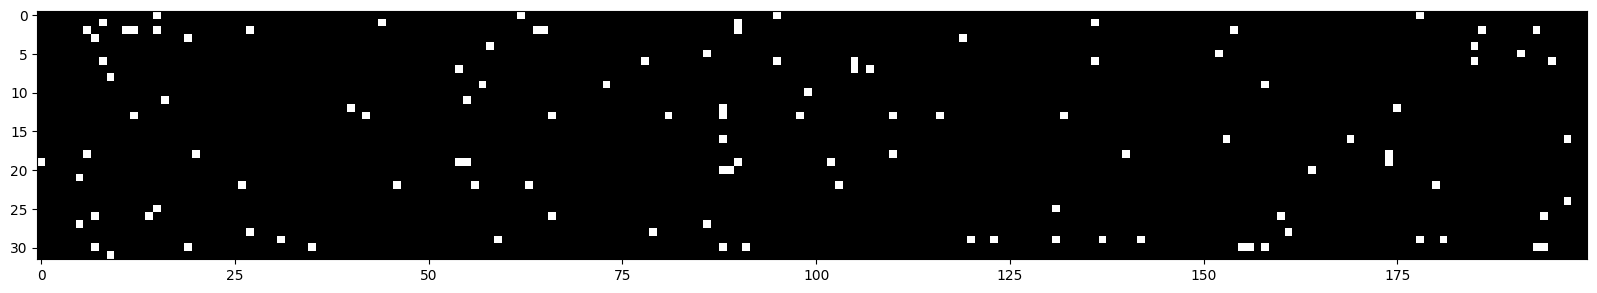

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

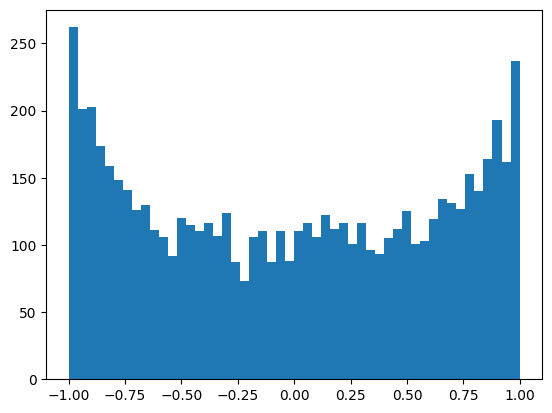

In [ ]:
plt.hist(h.view(-1).tolist(),50);

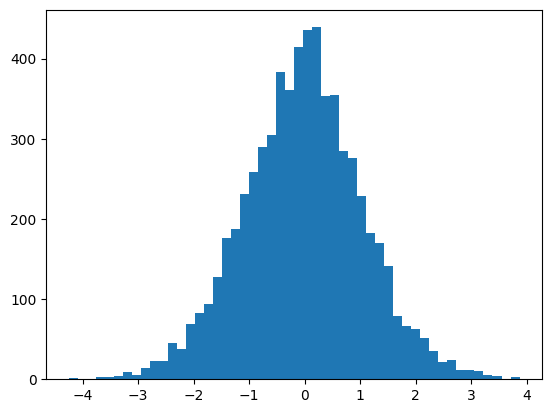

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

In [ ]:
@torch.no_grad() #no need to track gradients since we are not doing a backward pass, and we are not updating the parameters. This will make the code run faster
def split_loss(split):
    x,y =  {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]
    emb = C[x] #embedding lookup
    embcat = emb.view(emb.shape[0],-1) #concatenation of the embeddings
    hpreact = embcat @ W1 + b1 #pre-activation of the hidden layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #we use bnmean_running and bnstd_running to get meaningful mean and std eveb when the input example is one
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #logits
    loss = F.cross_entropy(logits, y) #loss
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1605958938598633
val 2.1729342937469482


In [ ]:
#sampling from the model
for _ in range(20):
   out =[]
   context = [0]*block_size

   while True:
      emb = C[torch.tensor([context])] #1,2,3 
      h = torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim = 1)
      ix = torch.multinomial(probs, num_samples = 1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
         break

   print(''.join(itos[i] for i in out))